# Lesson 6 - Multi-LoRA


In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

### Import required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

### Let's create a new model

We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [2]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

### Using a loop

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [4]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [6]:
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

### Let's try it!

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [9]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


### Let's benchmark our multi-LoRA system!

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [10]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [11]:
avg_latencies_loop = benchmark(model)

1 0.00013985395431518555
2 0.0001645359992980957
3 0.00018114805221557616
4 0.00020729494094848632
5 0.00023354673385620118
6 0.00026017045974731443
7 0.00029245710372924805
8 0.00031541013717651366
9 0.000331171989440918
10 0.0003629550933837891
11 0.00038962078094482424
12 0.000413907527923584
13 0.0004291086196899414
14 0.00046505117416381837
15 0.0004808201789855957
16 0.000512387752532959
17 0.0005307412147521973
18 0.0005638494491577149
19 0.0005816292762756348
20 0.0006050333976745605
21 0.000627927303314209
22 0.0006556224822998047
23 0.0006828651428222656
24 0.0006976680755615234
25 0.000734001636505127
26 0.0007579779624938965
27 0.0007822866439819336
28 0.000802274227142334
29 0.0008269023895263672
30 0.0008518714904785156
31 0.0008760695457458496
32 0.0008947906494140625
33 0.0009115705490112305
34 0.0009340691566467285
35 0.0009697608947753907
36 0.0009824171066284179
37 0.0010174050331115722
38 0.0010377497673034668
39 0.001042034149169922
40 0.0010842623710632323
41 0.00

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

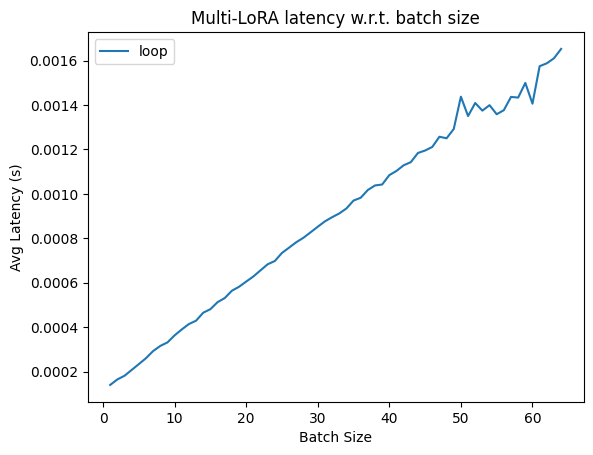

In [12]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

### Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [13]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [14]:
model = GatheredMultiLoraModel()

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [15]:
avg_latencies_gathered = benchmark(model)

1 0.0001249551773071289
2 0.002050222873687744
3 0.0017972173690795898
4 0.0022069997787475585
5 0.0021899895668029785
6 0.0023822550773620606
7 0.002576324462890625
8 0.002387894630432129
9 0.002196509838104248
10 0.0020315775871276856
11 0.0025944976806640623
12 0.002593388557434082
13 0.0025899534225463866
14 0.002596404552459717
15 0.002779499053955078
16 0.0025967397689819335
17 0.002789700984954834
18 0.0029766268730163576
19 0.0031657514572143554
20 0.002786095142364502
21 0.002402338981628418
22 0.0027886247634887696
23 0.002597892761230469
24 0.002587520122528076
25 0.0031862025260925293
26 0.0033572478294372557
27 0.0031802959442138673
28 0.002993692398071289
29 0.00317880916595459
30 0.003557952404022217
31 0.0031955995559692385
32 0.003578713893890381
33 0.003204647064208984
34 0.0029755330085754397
35 0.002985377311706543
36 0.003754287242889404
37 0.0032294745445251463
38 0.0034033451080322267
39 0.0035714592933654785
40 0.0033743066787719727
41 0.003177243232727051
42 0.

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

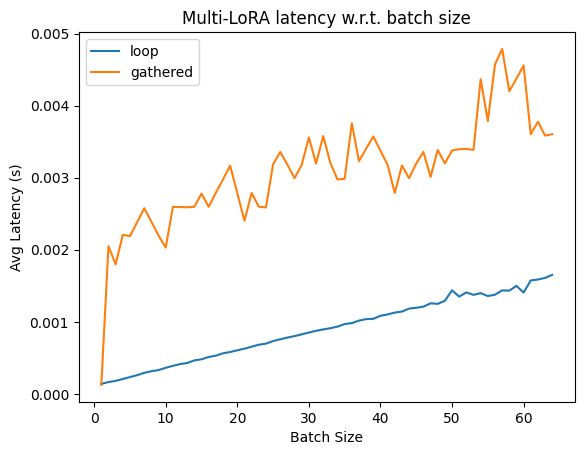

In [20]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()